[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cozek/hasoc_code/blob/master/notebooks/English/Task%20A%20-%20Outlier.ipynb)

# If working in colab, clone the repo

In [1]:
import os
import sys

try:
    __import__('google.colab')
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    os.system('rm -rf /content/hasoc_code/')
    os.system('git clone --recurse-submodules https://github.com/cozek/hasoc_code')
    sys.path.append('/content/hasoc_code/src')
    _o1 = 'wget https://github.com/plotly/orca/releases/download/v1.3.1/orca-1.3.1.AppImage -O /usr/local/bin/orca'
    _o2 = 'chmod +x /usr/local/bin/orca'
    _o3 = 'apt-get install xvfb libgtk2.0-0 libgconf-2-4'
    os.system(f'{_o1};{_o2};{_o3};')
else:
    sys.path.append('../../src')

# Import libraries

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import collections
from typing import Callable
import numpy as np
import pandas as pd
from tqdm import notebook
import importlib
import pprint
import nltk
import datetime
import os
from argparse import Namespace
import re
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [5]:
import utils.general as general_utils
import utils.data as data_utils
general_utils.set_seed_everywhere() #set the seed for reproducibility

# Set up the argspace/important_variables

In [95]:
args = Namespace(
    interactive = False, #set False for non interactive graphs
)

In [7]:
if not IN_COLAB:
    _prefix = '../../'
else : #for colab
    _prefix = '/content/hasoc_code/'
    #location of the train, dev and test csv
args.data_tsv = _prefix + 'data/english_dataset/english_dataset.tsv'
args.test_tsv = _prefix + 'data/english_dataset/hasoc2019_en_test-2919.tsv'

# Load the data tsv for Sub-task A
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

- (NOT) Non Hate-Offensive - This post does not contain any Hate speech, offensive content.
- (HOF) Hate and Offensive - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.

### Load the train set

In [8]:
hasoc_data_df = pd.read_csv(args.data_tsv, sep='\t')
hasoc_data_df_task_a = hasoc_data_df[['text','task_1']]
hasoc_data_df_task_a.columns.values[1] = 'label'
hasoc_data_df_task_a = hasoc_data_df_task_a[hasoc_data_df_task_a.label != 'NONE']
del hasoc_data_df #free memory

### Train set Samples

In [9]:
hasoc_data_df_task_a.sample(5)

,text,label
3286,#Assange is not a #rapist https://t.co/M4sfW7...,NOT
2876,#GandiNaaliAbuse | Where an MP says that he wi...,HOF
2996,"Candle light silent protest in MYSORE, by Myso...",NOT
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,HOF
1074,#ICC ...look at pak team...wht is going on.......,NOT


NOT    3591
HOF    2261
Name: label, dtype: int64


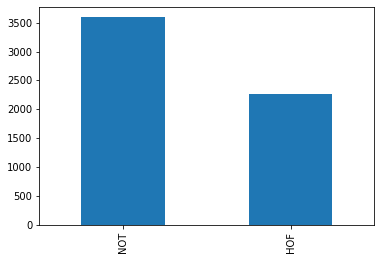

In [10]:
print(hasoc_data_df_task_a.label.value_counts())
hasoc_data_df_task_a.label.value_counts().plot(kind='bar')

### Split dataframe into train and validation

In [11]:
data_df = data_utils.Datasplitter.split_dataframe(hasoc_data_df_task_a, train_frac= 0.9, shuffle=True )

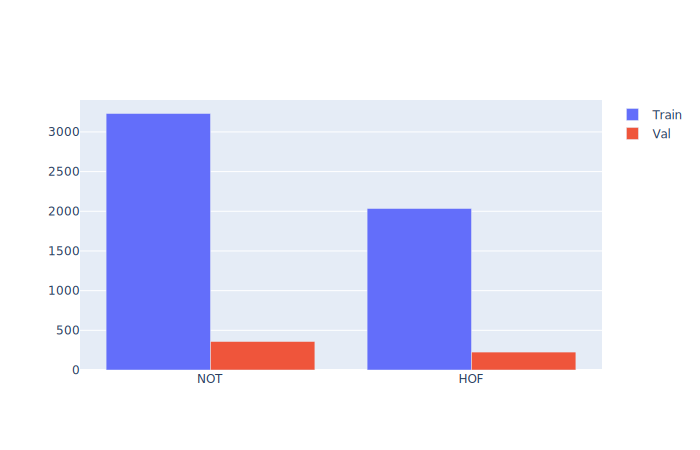

In [101]:
_data_df_train = data_df[data_df.split =='train'].label.value_counts()
_data_df_val = data_df[data_df.split =='val'].label.value_counts()

_val_fig = go.Figure(data=[
    go.Bar(name='Train', x=_data_df_train.index, y=_data_df_train.values),
    go.Bar(name='Val', x=_data_df_val.index, y=_data_df_val.values,)
])
_val_fig.update_layout(barmode='group')
_val_fig.show(renderer=(None if args.interactive else 'svg'))


### One-Class Classification using SVM

The first order of affairs is to check how we can best fit an OneClassSVM on each class.
We need to find out
- The size of suitable of the n-grams to make TFIDF out of
- The type of tokenization we want
    - Word level
    - Char level

We also need to know
- Should we just use ngrams of just one size ?
- Should we combine multiple ngrams within a range ? Say combining ngrams of size 1 upto 5 ?


In [13]:
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import sklearn.metrics

We define a function below that fits oneclass SVM each class. Its each class, it first fits the model on the train split and check it on the val split of the same class. From this we can find out the model that can fit both seen and unseen examples.

In [14]:
def check_one_class_svm(
    data_df: pd.DataFrame,
    analyzer :str = 'word',
    ngram_max :int = 60,
):
    '''Runs OneClassSVM on each class in the given DataFrame
    
    Args:
        data_df (pd.DataFrame): Dataframe containing columns ['text','label','split']
        analyzer (str) : Analyzer To use with TfidfVectorizer  
        ngram_max (int) : Max ngram size to check
        
    Returns:
        _fig : Plotly subplots
        lbl_accs : Train,Val Accuracy with each ngram size for each class
    
    '''
    ngram_max = ngram_max #max n that we check
    labels = set(data_df.label)


    _fig = make_subplots(
        rows=len(labels), cols=1,
        subplot_titles= [f'Class : {l}' for l in labels],
        shared_yaxes=True,
        x_title='ngram size',
        y_title='Accuracy',
    )
    
    lbl_accs = { spl:{ lbl:{} for lbl in labels} for spl in set(data_df.split) } 

    
    for i,lbl in enumerate(labels, start = 1):
        
        #saving train accuracy for each n for each split
        ngram_acc = { spl:{} for spl in set(data_df.split) } 

        #check the n in ngram 
        for n in notebook.tqdm(range(1,ngram_max+1), total = ngram_max):
            
            tfidf_vectorizer = TfidfVectorizer(ngram_range=(n,n), analyzer = analyzer)
            clf = OneClassSVM(gamma='auto')

            for spl in ['train','val']:
                
                #Get the samples with the corresponding label from the DF
                hate_text_df =\
                    data_df[ (data_df.split == spl) & (data_df.label == lbl) ]
                
                if spl == 'train':
                    hate_tfidf = tfidf_vectorizer.fit_transform(hate_text_df.text)
                    clf.fit(hate_tfidf)

                elif spl == 'val':
                    hate_tfidf = tfidf_vectorizer.transform(hate_text_df.text)
                

                preds = clf.predict(hate_tfidf)
                acc = sklearn.metrics.accuracy_score(
                    y_true = [1 for i in range(len(hate_text_df))],
                    y_pred = preds, 
                )
                
                ngram_acc[spl][n] = acc
                lbl_accs[spl][lbl][n] = acc
                    

        for spl in ['train','val']: 
            subfig = go.Scatter(
                    x = list(ngram_acc[spl].keys()),
                    y = list(ngram_acc[spl].values()),
                    mode = "lines+markers",
                    name=f'{lbl}-{spl}',
                )

            _fig.append_trace(subfig, row = i, col=1)


        

        
    _fig.update_layout(
            title = f"OneClass SVM for each class using {analyzer} n-grams",
        )
    
    return _fig, lbl_accs 

    

### Training OneClass SVM for each class with word ngrams

In [15]:
word_ngram_fig, word_ngram_lbl_accs = check_one_class_svm(
    data_df= data_df,
    analyzer = 'word',
    ngram_max  = 60,
)

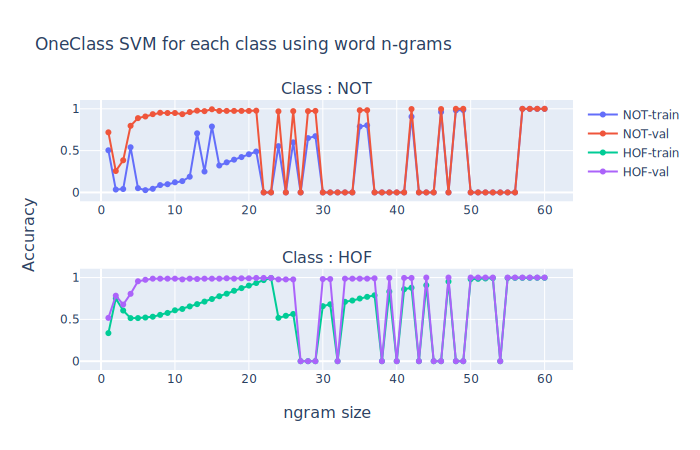

train : NOT  -> Best Acc: 0.9990717821782178 with n: 59
train : HOF  -> Best Acc: 0.9970515970515971 with n: 59
val : NOT  -> Best Acc: 1.0 with n: 48
val : HOF  -> Best Acc: 1.0 with n: 44


In [98]:
word_ngram_fig.show(renderer=(None if args.interactive else 'svg')) #remove renderer argument

for spl in ['train', 'val']:
    for lbl in set(data_df.label):
        ngram_dict = word_ngram_lbl_accs[spl][lbl]
        best_n = max(list(ngram_dict.items()), key = lambda x: x[1])    
        print(f'{spl} : {lbl}  -> Best Acc: {best_n[1]} with n: {best_n[0]}')

### Training OneClass SVM for each class with character ngrams

In [17]:
char_ngram_fig, char_ngram_lbl_accs = check_one_class_svm(
    data_df= data_df,
    analyzer = 'char',
    ngram_max  = 20,
)

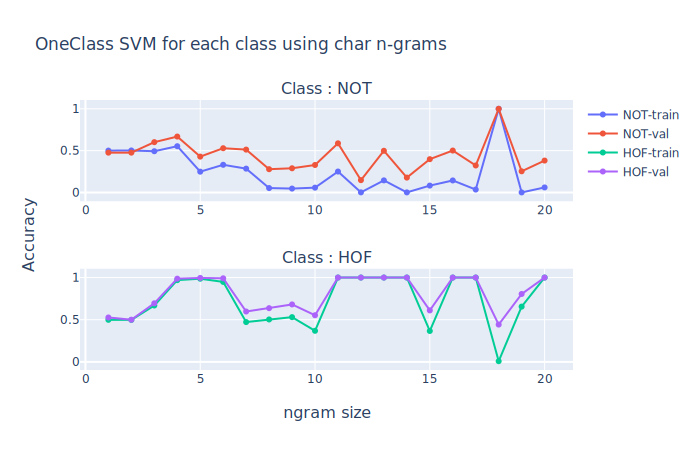

train : NOT  -> Best Acc: 1.0 with n: 18
train : HOF  -> Best Acc: 1.0 with n: 11
val : NOT  -> Best Acc: 1.0 with n: 18
val : HOF  -> Best Acc: 1.0 with n: 11


In [99]:
char_ngram_fig.show(renderer=(None if args.interactive else 'svg')) #remove renderer argument


for spl in ['train', 'val']:
    for lbl in set(data_df.label):
        ngram_dict = char_ngram_lbl_accs[spl][lbl]
        best_n = max(list(ngram_dict.items()), key = lambda x: x[1])    
        print(f'{spl} : {lbl}  -> Best Acc: {best_n[1]} with n: {best_n[0]}')

### Training OneClass SVM for each class with character_word_bounded ngrams

In [19]:
charwb_ngram_fig, charwb_ngram_lbl_accs = check_one_class_svm(
    data_df= data_df,
    analyzer = 'char_wb',
    ngram_max  = 30,
)

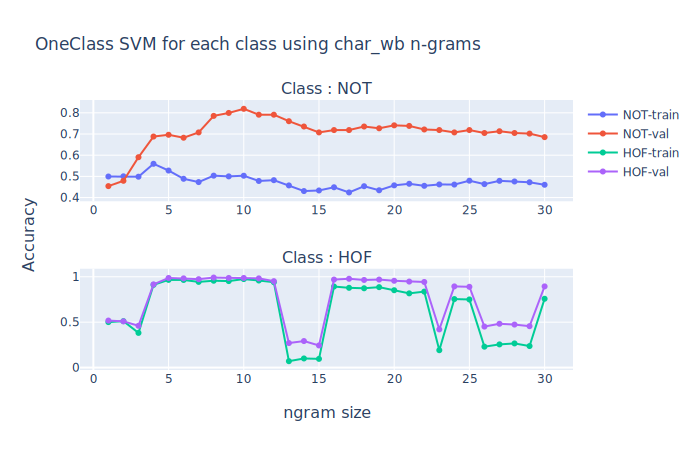

train : NOT  -> Best Acc: 0.5594059405940595 with n: 4
train : HOF  -> Best Acc: 0.9744471744471744 with n: 10
val : NOT  -> Best Acc: 0.8189415041782729 with n: 10
val : HOF  -> Best Acc: 0.9911504424778761 with n: 8


In [100]:
charwb_ngram_fig.show(renderer=(None if args.interactive else 'svg')) #remove renderer argument


for spl in ['train', 'val']:
    for lbl in set(data_df.label):
        ngram_dict = charwb_ngram_lbl_accs[spl][lbl]
        best_n = max(list(ngram_dict.items()), key = lambda x: x[1])    
        print(f'{spl} : {lbl}  -> Best Acc: {best_n[1]} with n: {best_n[0]}')

### Best model 
Both word level and char level did well. We could take either. But since char ngrams are more consistent in both train and val set, we will go with that. We can see that ngram size of 12 worked best for HOF and 16 for NOT. First we need to know why this perticular size of ngram ? Does it make sense ? For this we should probably check
- the lenght the samples
- and that too for both class

Checking most common ngrams

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(12,12))
vectorizer.fit(data_df.text)
_counter = collections.Counter(vectorizer.get_feature_names())
_counter.most_common(5)

[('00 after filing their resignations at the directors office they stand in',
  1),
 ('00 gmt maga johnmccainday trump2020 derangeddonald trump trumpisatraitor impeachtrumpnow wwg1wga rt impeachtrump',
  1),
 ('00 to 2019 06 15 15 00 gmt maga johnmccainday trump2020 derangeddonald', 1),
 ('000 000 amount amp he is in dubai now need your intervention', 1),
 ('000 amount amp he is in dubai now need your intervention imafraud', 1)]

Check avg num chars in each sample

In [22]:
_sample_lens = data_df.text.map(len)

In [23]:
_sample_lens.describe()

count    5852.000000
mean      178.698565
std        82.459246
min        14.000000
25%       113.000000
50%       170.000000
75%       247.000000
max       991.000000
Name: text, dtype: float64

We can conclude that there are no common n_grams and the ngram size that we found makes sense

## Can OneClassSVM detect hatespeech ?

We can use two appoaches
- _Approach 1_: Train OneClassSVM on HateSpeech and try to detect Harmless as novelty
- _Approach 2_: Train OneClassSVM on Harmless and try to detect HateSpeech as novelty

## Approach 1: Train OneClassSVM on HateSpeech and try to detect Harmless as novelty
We use all the HOF samples as train and all NOT samples for validation

In [56]:
hate_text_df_ = data_df[ (data_df.label == 'HOF') ]
harmless_text_df = data_df[ (data_df.label == 'NOT') ]

In [57]:
vectorizer_ = TfidfVectorizer(ngram_range=(11,11), analyzer='char')
hof_class_svm = OneClassSVM(gamma='auto')

In [59]:
vectorizer_.fit(hate_text_df_.text)

hof_tfidf = vectorizer_.transform(hate_text_df_.text)
harmless_tfidf = vectorizer_.transform(harmless_text_df.text)

In [62]:
hof_class_svm.fit(hof_tfidf)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [41]:
print( 
    'training acc: ',
    sklearn.metrics.accuracy_score(
        y_true = [1 for i in range(len(hate_text_df_))],
        y_pred = hof_class_svm.predict(hof_tfidf), 
    )
)

training acc:  1.0


In [63]:
print( 
    'acc: ',
    sklearn.metrics.accuracy_score(
        y_true = [-1 for i in range(len(harmless_text_df))],
        y_pred = hof_class_svm.predict(harmless_tfidf), 
    )
)


acc:  0.0


In [91]:
app1_train_accs = {}
app1_val_accs = {}
n_max = 20
for i in notebook.tqdm(range(1,n_max+1), total = n_max):
    vectorizer_ = TfidfVectorizer(ngram_range=(i,i), analyzer='char')
    hof_class_svm = OneClassSVM(gamma='auto')
    vectorizer_.fit(hate_text_df_.text)

    hof_tfidf = vectorizer_.transform(hate_text_df_.text)
    harmless_tfidf = vectorizer_.transform(harmless_text_df.text)
    
    hof_class_svm.fit(hof_tfidf)
    
    train_acc = sklearn.metrics.accuracy_score(
        y_true = [1 for i in range(len(hate_text_df_))],
        y_pred = hof_class_svm.predict(hof_tfidf), 
    )
    
    val_acc = sklearn.metrics.accuracy_score(
        y_true = [-1 for i in range(len(harmless_text_df))],
        y_pred = hof_class_svm.predict(harmless_tfidf), 
    )
    
    app1_train_accs[i] = train_acc
    app1_val_accs[i] = val_acc

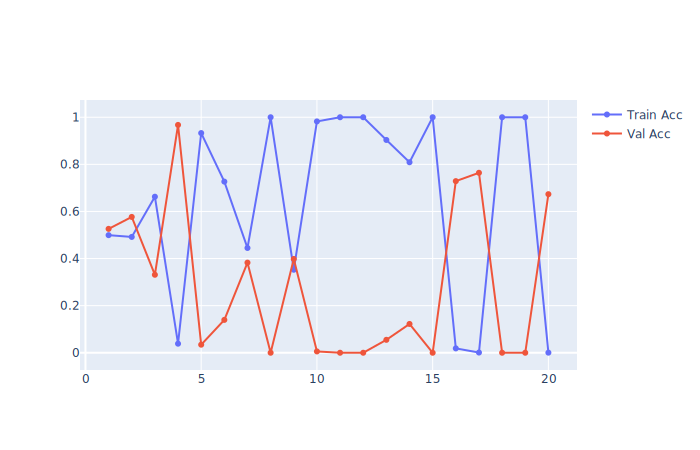

In [97]:
app1_fig = go.Figure()

app1_fig.add_trace(go.Scatter(
    x = list(app1_train_accs.keys()),
    y = list(app1_train_accs.values()),
    mode = "lines+markers",
    name=f'Train Acc',
)
                 )

app1_fig.add_trace(
    go.Scatter(
        x = list(app1_val_accs.keys()),
        y = list(app1_val_accs.values()),
        mode = "lines+markers",
        name=f'Val Acc',
    )
)
app1_fig.show(renderer=(None if args.interactive else 'svg'))

## _Approach 2_: Train OneClassSVM on Harmless and try to detect HateSpeech as novelty

In [93]:
app2_train_accs = {}
app2_val_accs = {}
n_max = 20
for i in notebook.tqdm(range(1,n_max+1), total = n_max):
    vectorizer_ = TfidfVectorizer(ngram_range=(i,i), analyzer='char')
    not_class_svm = OneClassSVM(gamma='auto')
    vectorizer_.fit(harmless_text_df.text)

    hof_tfidf = vectorizer_.transform(hate_text_df_.text)
    harmless_tfidf = vectorizer_.transform(harmless_text_df.text)
    
    not_class_svm.fit(harmless_tfidf)
    
    train_acc = sklearn.metrics.accuracy_score(
        y_true = [1 for i in range(len(harmless_text_df))],
        y_pred = not_class_svm.predict(harmless_tfidf), 
    )
    val_acc = sklearn.metrics.accuracy_score(
        y_true = [-1 for i in range(len(hate_text_df_))],
        y_pred = not_class_svm.predict(hof_tfidf), 
    )
    
    app2_train_accs[i] = train_acc
    app2_val_accs[i] = val_acc
    

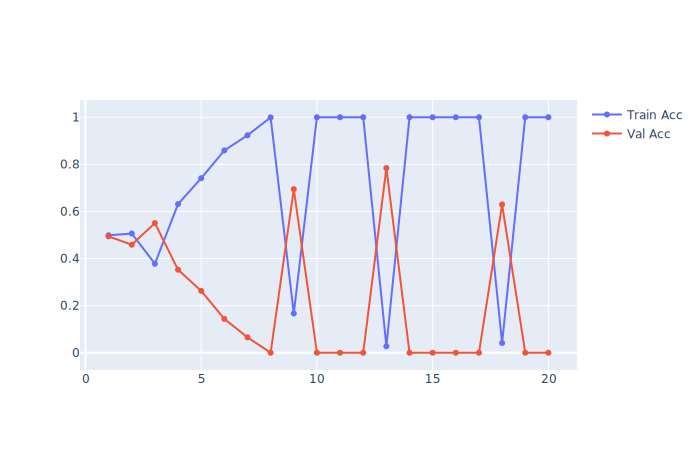

In [96]:
app2_fig = go.Figure()

app2_fig.add_trace(go.Scatter(
        x = list(app2_train_accs.keys()),
        y = list(app2_train_accs.values()),
        mode = "lines+markers",
        name=f'Train Acc',
    )
)

app2_fig.add_trace(
    go.Scatter(
        x = list(app2_val_accs.keys()),
        y = list(app2_val_accs.values()),
        mode = "lines+markers",
        name=f'Val Acc',
    )
)
app2_fig.show(renderer=(None if args.interactive else 'svg'))